In [2]:
import ipywidgets as widgets
from ipywidgets import Layout, HBox, Label, interact, fixed
from IPython.display import display, clear_output
import pandas as pd
from s3fs.core import S3FileSystem
import numpy as np
import shapefile
from shapely.geometry.polygon import LinearRing
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

import codecs
import json

#%matplotlib inline
#%matplotlib nbagg
%matplotlib notebook

from s3_functions import *
from shp_functions import *

In [3]:
s3 = S3FileSystem(anon=True)
bucket = 'ptrac-copano'
extent = (-97.3, -96.8, 27.9, 28.3)
zone_number = 14
zone_letter = 'R'
month_dict = {
    'April': '0401',
    'May': '0501',
    'June': '0601',
    'July': '0701',
    'August': '0801',
}
grid_resolution = 500

In [4]:
def read_data(year, month, coords):    
    #create the keys for the lat/lon files, this is their path in S3
    lat_key = 'data/{}/{}/lat.csv'.format(year, month)
    lon_key = 'data/{}/{}/lon.csv'.format(year, month)
    
    #pandas 0.20 uses s3fs to access S3 objects now (previous versions used boto or boto3)
    print('Reading latitude')
    lat = pd.read_csv(s3.open('{}/{}'.format(bucket, lat_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading longitude')
    lon = pd.read_csv(s3.open('{}/{}'.format(bucket, lon_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading velocity')
    outflw1 = read_outflw1(year, month, s3, bucket)
    print('Reading salinity')
    avesal = read_avesalD(year, month, s3, bucket)
    print('Done!')
    
    cn = [int(x) for x in list(outflw1.keys())]
    cknodes = coords.loc[cn]
    
    return lat, lon, outflw1, avesal, cknodes

In [19]:
def init_plot(extent, geoms):
    #ring here is the box where the particles are dropped
    ring_lats = [28.142815, 28.142622, 28.128572, 28.128588]
    ring_lons = [-97.057931, -97.041549, -97.041542, -97.057923]
    ring = LinearRing(list(zip(ring_lons, ring_lats)))
    #create the figure
    #fig = plt.figure(figsize=(12, 12)) #<-this is the right size for the matplotlib inline backend
    fig = plt.figure(figsize=(8, 8)) #<- this is the right size for the matplotlib notebook (nbagg) backend
    ax = fig.add_subplot(111, projection=ccrs.Miller())
    ax.set_extent(extent, ccrs.Miller())
    #this adds the shapefile
    ax.add_geometries(geoms, ccrs.Miller(), facecolor='none', edgecolor='black')
    #this adds the ring
    ax.add_geometries([ring], ccrs.Miller(), facecolor='none', edgecolor='red')
    return ax

In [20]:
def first_frame(ax, lat, lon, outflw1, cknodes, coords_clipped, grid_resolution, avesal, mask, index):
    global time_text, sctr, quiv, contf
    '''
    The index here is on a 30 minute interval, while the index for outflw1 is one hour
    and the index for avesal is daily...
    
    need to get the index for these that's closest to the index passed to the function
    '''
    o_index = outflw1[list(outflw1.keys())[0]].index.get_loc(index, method='nearest')
    a_index = avesal.index.get_loc(index, method='nearest')
    
    time_text = ax.text(0.02, 0.93, index, bbox=dict(facecolor='lightgray', alpha=1), 
                        fontsize=14, weight='medium', transform=ax.transAxes)
    sctr = ax.scatter(lon.loc[index], lat.loc[index], marker='.', facecolor='lime', edgecolor='k', linewidth=0.1, s=25)
    u = [outflw1[k]['u'][o_index] for k in outflw1]
    v = [outflw1[k]['v'][o_index] for k in outflw1]
    quiv = ax.quiver(cknodes['lon'], cknodes['lat'], u, v, scale=8, facecolor='white',
                     edgecolors='black', linewidth=0.3)
    lati = np.linspace(coords_clipped['lat'].min(), coords_clipped['lat'].max(), grid_resolution)
    loni = np.linspace(coords_clipped['lon'].min(), coords_clipped['lon'].max(), grid_resolution)
    sal = np.array(avesal[coords_clipped.index].iloc[a_index])
    sali = griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')
    sali.mask = ~mask
    levels = np.arange(0, 30.5, 0.5)
    ticks = np.arange(0, 30.5, 2)
    contf = ax.contourf(loni, lati, sali, zorder=0, cmap=plt.cm.seismic, vmin=0, vmax=30, 
                        levels=levels, extend='max', alpha=0.7)
    plt.show()
    
def update_frame(ax, lat, lon, lati, loni, outflw1, cknodes, coords_clipped, 
                 grid_resolution, avesal, mask, index_int):
    global contf
    '''
    To speed this up, need to check if the current index is in the outflw1 and avesal dataframes. 
    Currently they are being updated every single frame with the index that's closest to the current
    index but that is not necessary since velocity will only update on the hour and avesal will only
    update at the beginning of a new day
    '''
    index = lon.index[index_int]
    
    #o_index = outflw1[list(outflw1.keys())[0]].index.get_loc(index, method='nearest')
    #a_index = avesal.index.get_loc(index, method='nearest')
    
    time_text.set_text(index)
    
    #only update the velocity vectors on the hour
    if index in outflw1[list(outflw1.keys())[0]]['u'].index:
        u = [outflw1[k]['u'][index] for k in outflw1]
        v = [outflw1[k]['v'][index] for k in outflw1]
        quiv.set_UVC(u, v)
    
    #only update the salinity contours when a new day starts
    if index in avesal.index:
        #lati = np.linspace(coords_clipped['lat'].min(), coords_clipped['lat'].max(), grid_resolution)
        #loni = np.linspace(coords_clipped['lon'].min(), coords_clipped['lon'].max(), grid_resolution)
        sal = np.array(avesal[coords_clipped.index].loc[index])
        sali = griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')
        sali.mask = ~mask
        levels = np.arange(0, 30.5, 0.5)
        ticks = np.arange(0, 30.5, 2)
        for c in contf.collections: c.remove()
        contf = ax.contourf(loni, lati, sali, zorder=0, cmap=plt.cm.seismic, vmin=0, vmax=30, 
                            levels=levels, extend='max', alpha=0.7)
    
    offsets = sctr.get_offsets()
    offsets[:, 0] = lon.loc[index]
    offsets[:, 1] = lat.loc[index]
    sctr.set_offsets(offsets)
    
    plt.show()

In [21]:
class widget_handler():
    def __init__(self):
        self.year_dropdown = widgets.Dropdown(
            options = ['1993', '1995', '1997', '2007', '2009', '2011'],
            value = '1993',
            description = 'Year:',
        )
        
        self.month_dropdown = widgets.Dropdown(
            #options = ['April', 'May', 'June', 'July', 'August'],
            options = ['0401', '0501', '0601', '0701', '0801'],
            #value = 'April',
            value = '0401',
            description = 'Month:',
        )
        
        self.get_data = widgets.Button(
            description = 'Get Data',
            button_style = 'info',
            tooltip = 'Click here to start downloading the appropriate data',
            icon = '',
        )
        
        self.init_plot = widgets.Button(
            description = 'Initialize Plot',
            button_style = '',
            tooltip = 'Click here to initialize the plot with appropriate data',
            icon = '',
            disabled = True,
        )        
        
        #add print statements to these so it doesn't look stalled
        print('Reading coordinates')
        self.coords, self.coords_clipped, self.loni, self.lati = read_coords(zone_number, zone_letter,
                                                                             extent, grid_resolution,
                                                                             s3, bucket)
        print('Reading shapefile')
        self.r, self.polygon, self.geoms = read_shapefile(s3, bucket)
        print('Reading mask')
        self.mask = read_mask(s3, bucket)
        
        clear_output()
        
        self.get_data.on_click(self.get_data_click)
        self.init_plot.on_click(self.init_plot_click)
        
        display(self.year_dropdown, self.month_dropdown, self.get_data, self.init_plot)
        
    def get_data_click(self, b):
        self.year = self.year_dropdown.get_interact_value()
        self.month = self.month_dropdown.get_interact_value()
        clear_output()
        self.lat, self.lon, self.outflw1, self.avesal, self.cknodes = read_data(self.year, self.month, self.coords)
        self.get_data.set_trait('icon', 'check')
        self.get_data.set_trait('button_style', 'success')
        self.init_plot.set_trait('disabled', False)
        self.init_plot.set_trait('button_style', 'info')
        
    def init_plot_click(self, b):
        clear_output()
        self.ax = init_plot(extent, self.geoms)
        
        self.index = self.lon.index[0]
        
        #self.time_text, self.sctr, self.quiv, self.contf = \
        first_frame(self.ax, self.lat, self.lon, self.outflw1,
                    self.cknodes, self.coords_clipped, grid_resolution, 
                    self.avesal, self.mask, self.index)
        
        self.init_plot.set_trait('icon', 'check')
        self.init_plot.set_trait('button_style', 'success')
        
        play_button = widgets.Play(
            interval=200,
            value=0,
            min=0,
            max=len(self.lon),
            step=1,
            description='Press Play',
            disabled=False
        )
        
        interact(
            update_frame, 
            ax=fixed(self.ax),
            lat=fixed(self.lat),
            lon=fixed(self.lon),
            lati=fixed(self.lati),
            loni=fixed(self.loni),
            outflw1=fixed(self.outflw1),
            cknodes=fixed(self.cknodes),
            coords_clipped=fixed(self.coords_clipped),
            grid_resolution=fixed(grid_resolution),
            avesal=fixed(self.avesal),
            mask=fixed(self.mask),
            index_int=play_button,
        )
        
    def slider_change(self, b):
        print('slider changed')
        self.index = self.date_slider.get_interact_value()
        update_frame(self.ax, self.lat, self.lon, self.outflw1, self.cknodes,
                     self.coords_clipped, grid_resolution, self.avesal, self.mask,
                     self.index)

<IPython.core.display.Javascript object>


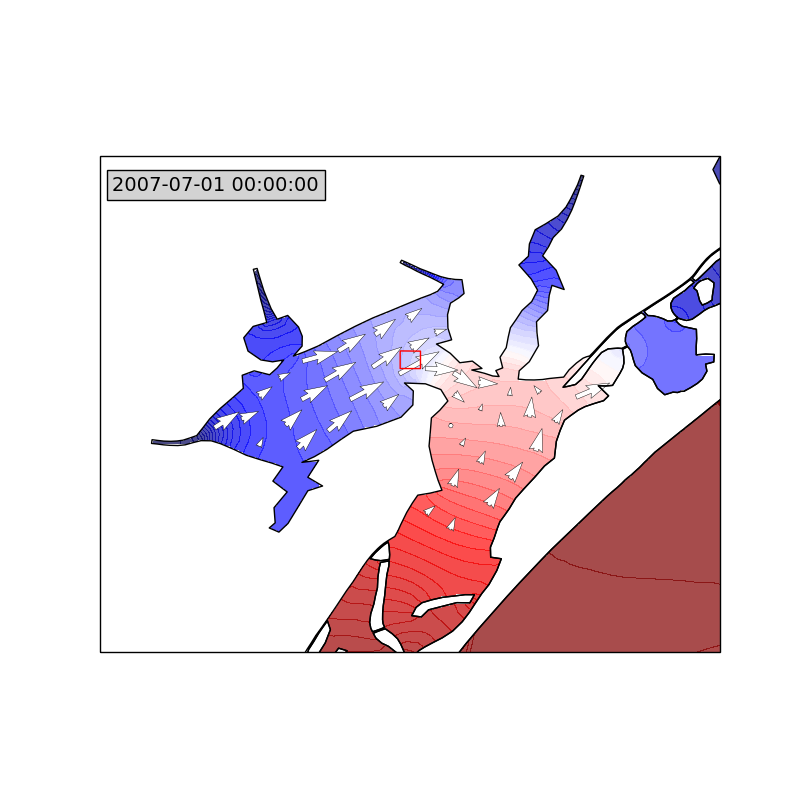

In [22]:
f = widget_handler()